### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


### Install Dependencies

In [2]:
# Clone repos we need
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git
!git clone https://github.com/huggingface/diffusers.git

# Handle all of the dependencies
!cd /content/profaile-pic-dev && chmod +x dreambooth/setup_dreambooth_env.sh
!cd /content/profaile-pic-dev && dreambooth/setup_dreambooth_env.sh
!cd /content/profaile-pic-dev && chmod +x inference/setup_inference_env.sh
!cd /content/profaile-pic-dev && inference/setup_inference_env.sh

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 67 (delta 32), reused 54 (delta 19), pack-reused 0
Unpacking objects: 100% (67/67), done.
Cloning into 'diffusers'...
remote: Enumerating objects: 15232, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 15232 (delta 123), reused 123 (delta 82), pack-reused 15036
Receiving objects: 100% (15232/15232), 10.31 MiB | 30.88 MiB/s, done.
Resolving deltas: 100% (10495/10495), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 4.7 MB/s 
     |████████████████████████████████| 18.7 MB 4.7 MB/s 
     |████████████████████████████████| 143 kB 4.5 MB/s 
     |████████████████████████████████| 5.8 MB 26.8 MB/s 
     |██████████

### Set up W&B and GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Create Run and load model from W&B

In [5]:
# Name for W&B
PROJECT_NAME = "stable-diffusion2"
# Increment
GROUP_NAME = "exp-finetuning-Nimages-all"
run = wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type="prompt_engineering")

wandb: Currently logged in as: janoliver. Use `wandb login --relogin` to force relogin


In [6]:
import torch, os
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

In [12]:
ARTIFACT_DIR = "/content/finetuned_model_checkpoint"
artifact = run.use_artifact('janoliver/stable-diffusion2/SD2.1_2750_finetuned_jseidenfuss:v0', type='model')
artifact_dir = artifact.download(ARTIFACT_DIR)

wandb: Downloading large artifact SD2.1_2750_finetuned_folder_jseidenfuss:v0, 9845.50MB. 18 files... 
wandb:   18 of 18 files downloaded.  
Done. 0:0:29.7


### Run inference

In [13]:
from PIL import Image

PRECISION = "no" # We don't use any type of optimization for this run

In [18]:
def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

def run_and_log_pipeline(prompt, nprompt, guid_scale, ninf_steps, h, w):
  # Make individual calls determninistic
  SEED = 52362
  g_cuda = torch.Generator(device='cuda').manual_seed(SEED)

  images = pipe(
    prompt,
    height=h,
    width=w,
    negative_prompt=nprompt,
    num_images_per_prompt=8,
    num_inference_steps=ninf_steps,
    guidance_scale=guid_scale,
    generator=g_cuda
  ).images

  # Create table
  columns=["seed", "prompt", "n_prompt", "guidance_scale", "num_inference_steps", "height", "width", "Images"]
  table_instance = wandb.Table(columns = columns)
  wandb_images = []
  for image in images:
    wandb_images.append(wandb.Image(image))
  row = [SEED, prompt, nprompt, guid_scale, ninf_steps, h, w, wandb_images]
  table_instance.add_data(*row)
  run.log({"prompt_engineering": table_instance})
  return images

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', adorable, attractive, hasselblad, candid street portrait']


  0%|          | 0/70 [00:00<?, ?it/s]

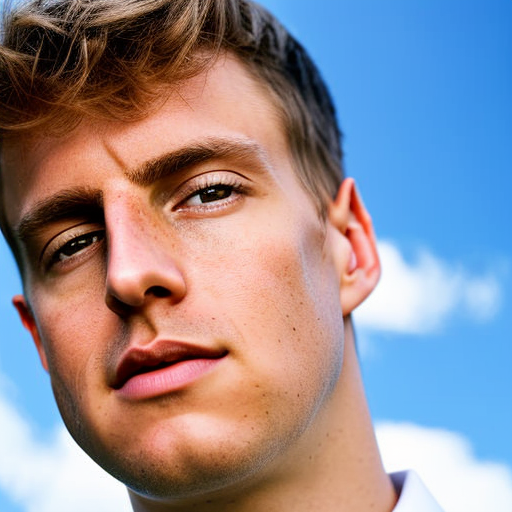

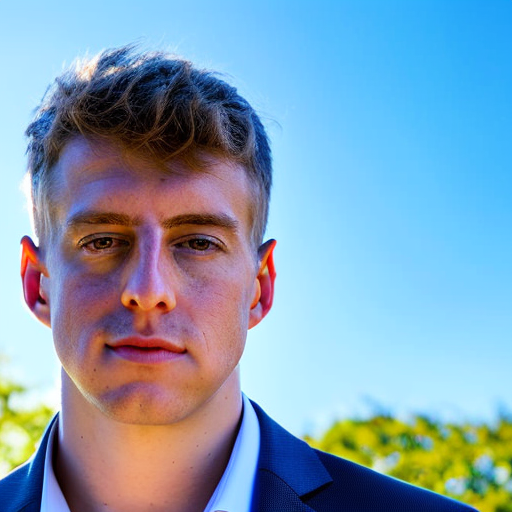

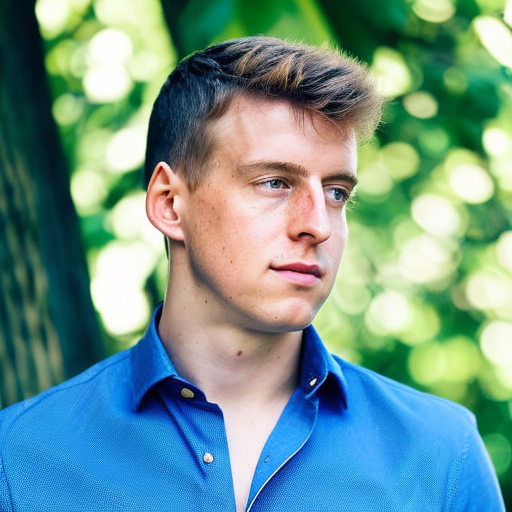

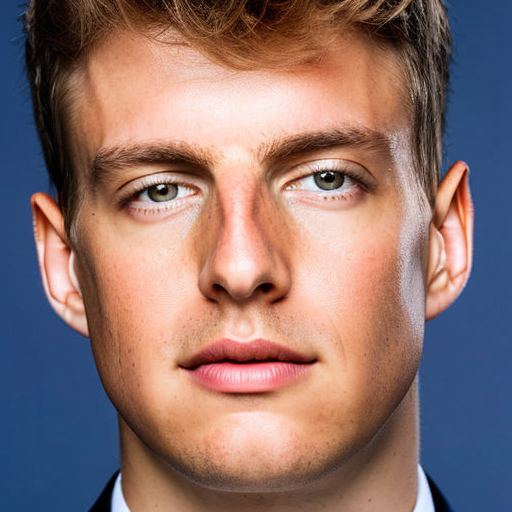

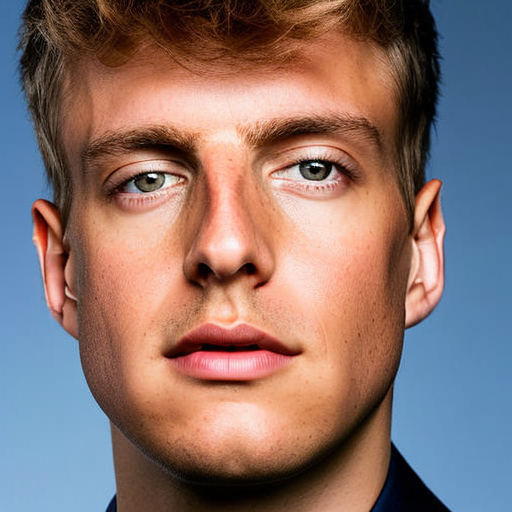

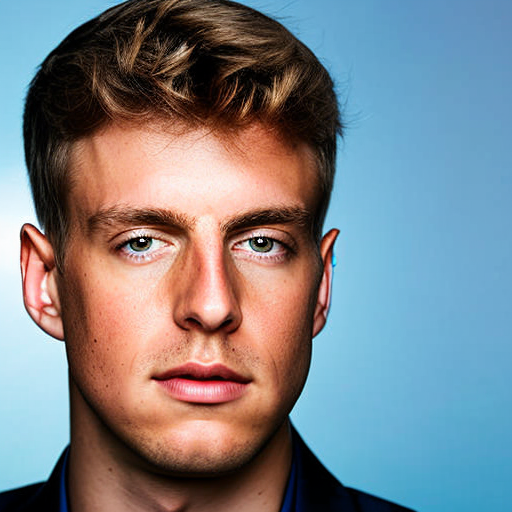

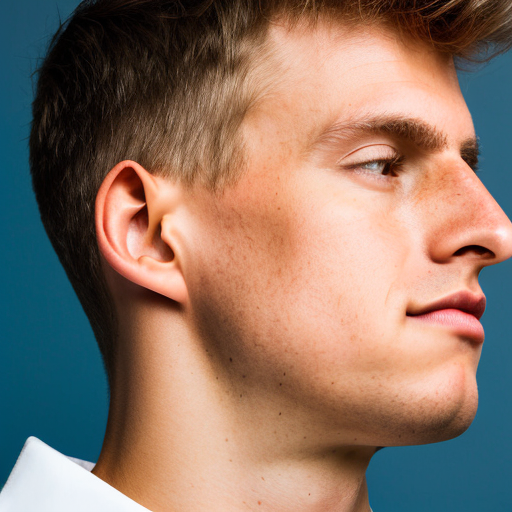

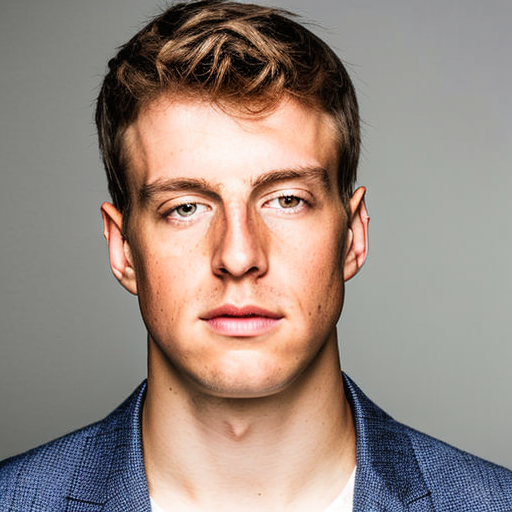

In [19]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display


MODEL_NAME = "/content/finetuned_model_checkpoint"

scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if PRECISION == "fp16":
  pipe = StableDiffusionPipeline.from_pretrained(MODEL_NAME, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionPipeline.from_pretrained(MODEL_NAME, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float32).to("cuda")

# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

prompt = "photo of face and shoulders of jseidenfuss man in a blue suit from the front, front view, closeup, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait"
negative_prompt = "blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white "
guidance_scale = 7
num_inference_steps = 70
height = 512
width = 512


images = run_and_log_pipeline(prompt, 
                              negative_prompt, 
                              guidance_scale, 
                              num_inference_steps, 
                              height, 
                              width)
for image in images:
  display(image)
del pipe